# Develop Robot keyword base on OOP
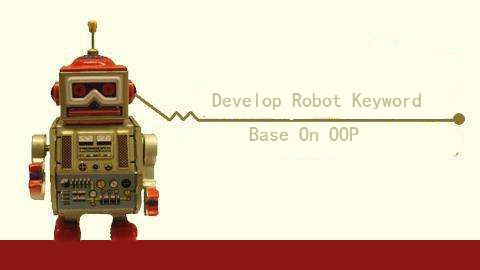
## <center>wang liyao (leo)</center>

## what's OOP

## why we need OOP

## robot keyword develop & OOP

## Low-level keyword development demo

### execute shell command keyword

** implement a keyword to execute shell command on remote linux pc **

** 实现一个可以在远程linux系统的pc上执行shell 命令的keyword **

### Procedure Oriented Programming

In [ ]:
#interface.py

import paramiko
def execute_shell_command(cmd, host, username, password):
    ssh = paramiko.SSHClient()
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    ssh.connect(host, 22, username, password)
    stdin,stdout,stderr = ssh.exec_command(cmd)
    outmsg, errmsg = stdout.read(),stderr.read()
    return outmsg
    ssh.close()

### add requirement

but one day, our customer need two keyword:
1. “get ethernet port ip”, the inputt arguments is ethernet name and output is ip address
2. "get remote host name", the output is host name

In [ ]:
#interface.py

import paramiko
import re

def get_ethernet_ip_address(eth_name, host, username, password):
    search_command = 'sudo ifconfig {}'.format(eth_name)
    result = execute_shell_command(search_command, host, username, password)
    pattern = r"inet addr:(\d{1,4}.\d{1,4}.\d{1,4}.\d{1,4})"
    for line in stdout.split('\n'):
        ret = re.search(pattern, line)
        if ret:
            result = ret.groups()[0]
    return result

def get_host_name(host, username, password):
    command = "hostname"
    result = execute_shell_command(command)
    return result.strip()


def execute_shell_command(cmd, host, username, password):
    ssh = paramiko.SSHClient()
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    ssh.connect(host, 22, username, password)
    stdin,stdout,stderr = ssh.exec_command(cmd)
    outmsg, errmsg = stdout.read(),stderr.read()
    return outmsg
    ssh.close()


### change requirement again

** If one day user find get_ethernet_ip_address keyword use too much time when execute command in local pc, it seems not necessary via ssh execute local comand ** 

In [ ]:
#interface.py

import paramiko
import subprocess
import re

def get_ethernet_ip_address(eth_name, host, username, password):
    search_command = 'sudo ifconfig {}'.format(eth_name)
    if host == '127.0.0.1' or host == 'localhost':
        result = execute_local_command(search_command)
    else:
        result = execute_shell_command(search_command, host, username, password)
    pattern = r"inet addr:(\d{1,4}.\d{1,4}.\d{1,4}.\d{1,4})"
    for line in stdout.split('\n'):
        ret = re.search(pattern, line)
        if ret:
            result = ret.groups()[0]
    return result

def get_host_name(host, username, password):
    command = "hostname"
    if host == '127.0.0.1' or host == 'localhost':
        result = execute_local_command(scommand)    
    else:
        result = execute_shell_command(command, host, username, password)
    return result.strip()

def execute_shell_command(cmd, host, username, password):
    ssh = paramiko.SSHClient()
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    ssh.connect(host, 22, username, password)
    stdin,stdout,stderr = ssh.exec_command(cmd)
    outmsg, errmsg = stdout.read(),stderr.read()
    return outmsg
    ssh.close()

def execute_local_command(cmd):
    result = subprocess.check_output(cmd)
    return result


### change requirement once again
** one day our boss tell me maybe use SSHLibrary better than paramiko  **

In [ ]:
#interface.py

import paramiko
import subprocess
from SSHLibrary import SSHClient
import re

def get_ethernet_ip_address(eth_name, host, username, password):
    search_command = 'sudo ifconfig {}'.format(eth_name)
    if host == '127.0.0.1' or host == 'localhost':
        result = execute_local_command(search_command)
    else:
        result = execute_shell_command_new(search_command, host, username, password)
    pattern = r"inet addr:(\d{1,4}.\d{1,4}.\d{1,4}.\d{1,4})"
    for line in stdout.split('\n'):
        ret = re.search(pattern, line)
        if ret:
            result = ret.groups()[0]
    return result

def get_host_name(host, username, password):
    command = "hostname"
    if host == '127.0.0.1' or host == 'localhost':
        result = execute_local_command(scommand)    
    else:
        result = execute_shell_command_new(command, host, username, password)
    return result.strip()


def execute_shell_command(cmd, host, username, password):
    ssh = paramiko.SSHClient()
    ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    ssh.connect(host, 22, username, password)
    stdin,stdout,stderr = ssh.exec_command(cmd)
    outmsg, errmsg = stdout.read(),stderr.read()
    ssh.close()
    return outmsg

def execute_local_command(cmd):
    result = subprocess.check_output(cmd)
    return result

def execute_shell_command_new(cmd, host, username, password):
    client = SSHClient(host)
    client.login(username, password)
    result, _, _ = client.execute_command(cmd)
    client.logout()
    return result
execute_shell_command_new('sudo ifconfig', '192.168.99.100', 'docker', 'tcuser')

### what's the disadvantage about all the previous code?

### use OOP refactor the code

In [17]:
# imp.py
import paramiko

class HostAccess(object):

    def __init__(self, connection):
        self.con = connection

    def get_ethernet_ip_addr(self, eth_name):
        result = ""
        stderr, stdout = self.con.exec_command("ifconfig {}".format(eth_name))
        pattern = r"(inet addr:\d{1,4}.\d{1,4}.\d{1,4}.\d{1,4})"
        for line in stdout.split('\n'):
            ret = re.search(pattern, line)
            if ret:
                result = ret.groups()[0]
        return result

    def get_host_name(self):
        stderr, stdout = self.con.exec_command('hostname')
        result = stdout.strip()
        return result


class SshConnection(object):
    def __init__(self, host,username, password, port=22):
        self.host = host
        self.port = port
        self.username = username
        self.password = password
        self.con = None

    def connect(self):
        self.con = paramiko.SSHClient()
        self.con.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        self.con.connect(self.host, self.port, self.username, self.password)

    def exec_command(self, command):
        stdin, stdout, stderr = self.con.exec_command(command)
        ret = stdout.read()
        return ret

    def disconnect(self):
        self.con.close()


# interface.py
class Interface(object):

    def __init__(self):
        self.ssh_con = None

    def setup_connection(self, **kwargs):
        host_ip = kwargs.get('host')
        username = kwargs.get('username')
        password = kwargs.get('password')
        self.ssh_con = SshConnection(host_ip, username, password)
        self.ssh_con.connect()
        self.access_obj = HostAccess(self.ssh_con)

    def execute_command_on_host(command):
        return self.ssh_conn.exec_command(command)

    def get_ethernet_ip_address(self, **kwargs):
        return self.access_obj.get_lmp_ip_addr()
    
    def get_host_name():
        return self.acess.obj.get_host_name()

    def teardown_connection(self, **kwargs):
        self.ssh_con.disconnect()


### local don't need ssh only need add a new class

In [ ]:
# imp.py
import subprocess

class LocalSshConnection(object):
    def __init__(self):
        pass
    def connect(self):
        pass
    def disconnect(self):
        pass
    def exec_command(self, command):
        result = subprocess.check_output(cmd)
        return result

In [ ]:
# imp.py
import paramiko
import subprocess
class HostAccess(object):
    def __init__(self, connection):
        self.con = connection
    def get_ethernet_ip_addr(self, eth_name):
        result = ""
        stderr, stdout = self.con.exec_command("ifconfig {}".format(eth_name))
        pattern = r"(inet addr:\d{1,4}.\d{1,4}.\d{1,4}.\d{1,4})"
        for line in stdout.split('\n'):
            ret = re.search(pattern, line)
            if ret:
                result = ret.groups()[0]
        return result
    def get_host_name(self):
        stderr, stdout = self.con.exec_command('hostname')
        result = stdout.strip()
        return result    
class LocalSshConnection(object):
    def __init__(self):
        pass
    def connect(self):
        pass
    def disconnect(self):
        pass
    def exec_command(self, command):
        result = subprocess.check_output(cmd)
        return result
class SshConnection(object):
    def __init__(self, host,username, password, port=22):
        self.host = host
        self.port = port
        self.username = username
        self.password = password
        self.con = None
    def connect(self):
        self.con = paramiko.SSHClient()
        self.con.set_missing_host_key_policy(paramiko.AutoAddPolicy())
        self.con.connect(self.host, self.port, self.username, self.password)
    def exec_command(self, command):
        stdin, stdout, stderr = self.con.exec_command(command)
        ret = stdout.read()
        return ret
    def disconnect(self):
        self.con.close()
# interface.py
class Interface(object):
    def __init__(self):
        self.ssh_con = None
    def setup_connection(self, **kwargs):
        host_ip = kwargs.get('host')
        username = kwargs.get('username')
        password = kwargs.get('password')
        # self.ssh_con = SshConnection(host_ip, username, password)
        ssh_con_dict = {'127.0.0.1': LocalSshConnection, 'localhost': LocalSshConnection}
        self.ssh_con = ssh_con_dict.get(host_ip, SshConnection)
        self.ssh_con.connect()
        self.access_obj = HostAccess(self.ssh_con)
    def execute_command_on_host(command):
        return self.ssh_conn.exec_command(command)
    def get_ethernet_ip_address(self, **kwargs):
        return self.access_obj.get_lmp_ip_addr()
    def get_host_name():
        return self.acess.obj.get_host_name()
    def teardown_connection(self, **kwargs):
        self.ssh_con.disconnect()


### ssh need Sshlibrary refactor

In [19]:
# imp.py
from SSHLibrary import SSHClient
class SshConnection_new(object):
    def __init__(self, host,username, password, port=22):
        self.host = host
        self.port = port
        self.username = username
        self.password = password
        self.con = None
    def connect(self):
        self.con = SSHClient(self.host)
        self.con.login(self.username, self.password)
    def exec_command(self, command):
        stdin, stdout, stderr = self.con.exec_command(command)
        ret = stdout.read()
        return ret
    def disconnect(self):
        self.con.logout()

### POP vs OOP

# another low-level keyword development demo

### impemen  "kill process" keyword
Users have a requirement to implement a keyword to kill process, input arguments is a list of the "process name". 

In [ ]:
import subbprocess
def kill_process(*process_list):
    for each_process in process_list:
        ppid = subprocess.check_output("ps -ef |grep {} |grep -v grep |awk -F ' ' '{print $2}'".format(each_process))
        ret = subbprocess.call('sudo kill - 9 {}'.format(ppid))

### "bug" driven keyword need be modified
One day, our user wanted to kill the kibana process with this keyword, but found that it didn't work. then we found out that the kibana process was not named kibana but node

In [2]:
import subprocess
def kill_process(*process_list):
    for each_process in process_list:
        if each_p_process == 'kibana':
            each_process = 'node'
        ppid = subprocess.check_output("ps -ef |grep {} |grep -v grep |awk -F ' ' '{print $2}'".format(each_process))
        ret = subbprocess.call('sudo kill - 9 {}'.format(ppid))

### refactor the 'kill process' keyword with OOP

In [4]:
import subprocess
class Process(object):
    def __init__(self, name):
        self.process_name = name
    def pid(self):
        return subprocess.check_output("ps -ef |grep {} |grep -v grep |awk -F ' ' '{print $2}'".format(process_name))
    def start(self):
        pass
    def stop(self):
        subbprocess.call('sudo kill - 9 {}'.format(self.pid))
class KibanaProcess(Process):
    def __init__(self, name):
        self.process_nme = 'node'
class ProcessFactory(object):
    def get_process_instant(self, name):
        ssh_con_dict = {'kibana': KibanaProcess}
        process_class = ssh_con_dict.get(name, Process)
        return process_class(name)
class ProcessControl(object):
    def __init__(self, process_name_list):
        self.ppid = None
        self.process_name_list = process_name_list
    def stop(self):
        for process_name in self.process_name_list:
            ProcessFactory().get_process_instant(process_name).stop()
def kill_process(*process_list):
    ProcessControl(process_list).stop()
                

### add new process

In [ ]:
class BtsLogProcess(Process):
    def __init__(self, name):
        self.process_nme = 'syslog.py'

class SiteManagerProcess(Process):
    
    def __init__(self, name):
        self.process_nme = 'java'

# High-level keyword development demo

Suppose we already have capture syslog, ttitrace log and aatrace message log(every have start and stop * log keywords), and one day user want us to implement a new common keyword for capture all the logs

### POP implementation

In [6]:
# interface.py
def start_capture_common_logs(syslog=True, ttitrace=True, aatrace=True, log_save_path="/tmp"):
    start_syslog(log_save_path)
    start_ttitrace(log_save_path)
    start_aaMessageTrace(log_save_path)

def stop_capture_common_logs():
    stop_syslog()
    stop_ttitrace()
    stop_aaMessageTrace() 

### new requirement
user want provide the aatrace profile which include the aatrace message filter, beside, user also want save the different log to different path

In [ ]:
# interface.py
def start_capture_common_logs(syslog=True, ttitrace=True, aatrace=True, log_save_path="/tmp"):
    start_syslog(syslog_save_path)
    start_ttitrace(ttitrace_save_path)
    start_aaMessageTrace(aatrace_save_path)

def stop_capture_common_logs():
    stop_syslog()
    stop_ttitrace()
    stop_aaMessageTrace() 